# Setting up Python library - Installing dependencies

```pip install notebook```

[Pytorch installation](https://pytorch.org/get-started/locally/)

[PyG installation](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) and dependencies: ```pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cpu.html```

```pip install matplotlib```

```pip install rasterio```

In [ ]:
import importlib

libraries = [
    "notebook",
    "torch",
    "torch_cluster",
    "numpy",
    "torch_geometric",
    "matplotlib",
    "rasterio",
    "glob"
]

for lib in libraries:
    try:
        if not importlib.util.find_spec(lib):
            # raise ImportError("Package '%s' is not installed" % lib)
            !pip install lib
    except ImportError as e:
        print(e)

# PyG

[PyG](https://pytorch-geometric.readthedocs.io/en/latest/index.html) (PyTorch Geometric) is a library built upon  [PyTorch](https://pytorch.org/) to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data.

PyG provides two abstract classes for datasets: `torch_geometric.data.Dataset` and `torch_geometric.data.InMemoryDataset`.

The [latter](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.InMemoryDataset.html#torch_geometric.data.InMemoryDataset) inherits from the former and is designed to be used when your dataset fits into CPU memory.

In this session we will use a class which has been written to inherit from `torch_geometric.data.InMemoryDataset` to load our remote sensing dataset.

We use two classes (found in the `Graph.py` file in this repository)

* `AirQualityClassification`
* `AirQualityRegression`


In [2]:
import torch_geometric.transforms as T

from Graph import AirQualityClassification, AirQualityRegression

In [3]:
aq_regression = AirQualityRegression(
    seed=0, pre_transform=T.KNNGraph(k=10, force_undirected=True), train_ratio=0.2, val_ratio=0.1
)

Processing...
Done!


In [4]:
aq_classification = AirQualityClassification(
    seed=0, pre_transform=T.KNNGraph(k=10, force_undirected=True), train_ratio=0.2, val_ratio=0.1
)

Processing...
Done!


When we create an instance of our class (as performed above), because it is based on the `torch_geometric.data.InMemoryDataset` class, it performs two key operations:

* If any of the files in `InMemoryDataset.raw_file_names()` are missing, then the `InMemoryDataset.download()` method is performed

* If any of the files in `InMemoryDataset.processed_file_names()` are missing, then the `InMemoryDataset.process()` method is performed

Because we have already have the remote sensing input files downloaded in this repository (inside `data` folder) you will notice that neither `AirQualityRegression` or `AirQualityClassification` provide a `download()` method or a `raw_file_names` property. Nothing happens for that part in our example.

In [5]:
print(aq_regression.has_download)
print(aq_classification.has_download)

False
False


We do provide processing steps though. These load the inputs and define how we get our dataset graph's:

* `x` input features
* `y` output values/labels
* `edge_index` (describes how graph nodes are connected i.e. could be used to find graph adjacency matrix)

> **To apply a similar approach to your own datasets you can borrow from the classes in `Graph.py` and write new/modified `process()` methods.**

The code inside the `process` function should write file(s) returned in `InMemoryDataset.processed_file_names()` list. The next time you create an instance of the class it will load from file rather than running `process()` again.

## Loading our classification dataset: the `process()` method

We use two functions written in the repository's `utils.py` file:

* `utils.open_pm25()`
* `utils.open_land_cover()`

### Inputs (air quality values)

In [6]:
import utils

pm25 = utils.open_pm25()

In [7]:
print(pm25.shape)

(45, 65, 2208)


In this case we are loading [CAMS data](https://atmosphere.copernicus.eu/cams-air-quality-data-quality-assured) (a forecast) for the surface level PM2.5 concentration.

These files are found in the folder `data/PM2_5`.

For each `.tif` file in the folder we have a matrix of PM2.5 concentrations over a region in North Italy. There is a file for each hour of the day for 92 days.

The data is quite coarse (each pixel represents 10x10km area) so each matrix is of shape 45x65 and we have 2208 temporal data points. The result is an array of shape 45x65x2208.

In [8]:
import matplotlib.pyplot as plt

Time series visualisation:

Text(0, 0.5, 'PM2.5 concentration')

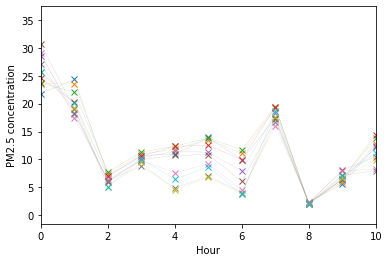

In [9]:
for series in pm25.reshape(-1, pm25.shape[-1])[:10]:
    plt.plot(series, lw=.1, marker='x')
plt.xlim(0, 10)
plt.xlabel("Hour")
plt.ylabel("PM2.5 concentration")

Single time stamp (i.e. region of North Italy)

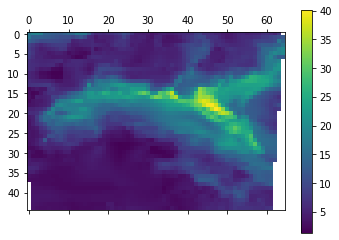

In [10]:
mappable = plt.matshow(pm25[..., -1])
plt.colorbar(mappable)

### Outputs (land cover classes)

In [11]:
land_cover = utils.open_land_cover()
print(land_cover.shape)

(45, 65)


In this demonstration we are going to try and predict a land cover class label from our air quality time series. The labels in this case are provided by the Copernicus Land cover products ([CORINE](https://land.copernicus.eu/en/products/corine-land-cover)).

The CORINE product is available at different levels i.e. how specific/broad each land cover class is. Here we are considering the Level 2 classes.

In [12]:
land_cover_labels = utils.open_land_cover_colormap()
for key in land_cover_labels.keys():
    print(key)

Urban fabric
Industrial commercial and transport units
Mine dump and construction sites
Artificial non-agricultural vegetated areas
Arable land
Permanent crops
Pastures
Heterogeneous agricultural areas
Forests
Shrub and/or herbaceous vegetation associations
Open spaces with little or no vegetation
Inland wetlands
Coastal wetlands
Inland waters
Marine waters


In [13]:
print(f"Predicting one of {len(land_cover_labels)} classes")

Predicting one of 15 classes


### Variable normalisation

In this example our input features (PM2.5 concentrations) vary from about 0 to 40.

Generally speaking, it is good practice to perform normalisation of your data before you start optimising your model parameters. Without normalisation you might run into a number of issues with exploding gradients and generally poor convergence.

There are many [excellent resources](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/) out there which discuss this topic in greater detail.

If you look in `AirQualityRegression.process()` or `AirQualityClassification.process()` you will see I perform a min/max scaling to keep variables in the range 0 to 1. This method is sensitive to outliers so you may want to consider other more robust normalisation methods in your own research.

## The graph

Inside `AirQualityRegression.process()` and `AirQualityClassification.process()` we use `torch_geometric.data`'s `Data` class.

This is the object which is eventually written to a file.

In our application we provide three arguments:

* `pos`
* `x`
* `y`

We don't actually provide the graph connections here. It is possible, if you have edges you would explicitly like to use to pass them using the `edge_index` argument rather than `pos` here.

When we loaded the dataset you will notice we passed a `pre_transform` argument:

In [14]:
aq_classification = AirQualityClassification(
    seed=0, pre_transform=T.KNNGraph(k=10, force_undirected=True), train_ratio=0.2, val_ratio=0.1
)

`T.KNNGraph(k=10, force_undirected=True)` describes how the graph is connected. The [docs](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.transforms.KNNGraph.html#torch_geometric.transforms.KNNGraph) describe that it "creates a k-NN graph based on node positions data.pos"

i.e. if you plotted each node's pos in space, you create a graph edge connecting each node to the k other nodes near it, in this case, the nearest 10 neighbours.

> Note, we use `force_undirected=True` to create a symmetric adjacency matrix meaning graph edges are not directional. If node A is connected to node B then vice versa is true also.

# The neural network (GCN)

In `train.py` you will find a class named `GCN`. It is an implementation based on a popular geometric neural network from [Kipf and Welling](https://arxiv.org/abs/1609.02907).

## Graph convolutional layer

It has two graph convolutional layers, each of which use `torch_geometric.nn`'s `GCNConv` layer (with documentation [here](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html)).

Mathematically it implements:

$$\mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},$$

where $\mathbf{X}^{\prime}$ is the layer output, $\mathbf{\hat{D}}$ and $\mathbf{\hat{A}}$ are function's of the graph's adjacency matrix, $\mathbf{X}$ is the input features and $\mathbf{\Theta}$ are the layer's parameters to be optimised.

$\mathbf{X}$ has $N$ rows and $C$ columns where $N$ is the number of nodes in the graph and $C$ is the number of features describing each node.

$\mathbf{\Theta}$ has $C$ rows and $F$ features. You can choose $F$, it gives the number of output features per node in the layer's output.

The operation $\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2}$ is essentially a messsage passing step. The resulting output feature will be a weighted sum of the features of all the nodes in the imediate 1-hop vicinity of the given node.

Think of it as a propagation/sharing/smoothing of features in the local area of the graph.

In some applications where the graph doesn't change, it makes sense to compute $\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2}$ only once and to store it:

```
        self._gcn0 = GCNConv(
            ...
            cached=True,
            ...
        )
```

This is what the `cached=True` argument does. If you need to compute $\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2}$ each forward pass then set `cached=False`.

## Output activation functions

$$\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

For a classification task the softmax output activation function is generally chosen.
Given a vector input it outputs a vector with entries that lie between 0 and 1 and when summed the entries equal 1. It can therefore be used to represent a probability distribution with each entry representing the probability that the model input belongs to the ith class.

For a regression task you can use a linear activation function (i.e. no activation function at all) since the output does not necessarily lie within a specific range (for most applications).

## Model hyperparameters

* number of channels, $C$ (i.e. how many features in the output of first GCNConv layer)
* dropout_rate
    * The GCN model has [dropout layers](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html). By default it is set to 0.5 but this can be varied from 0 to closer to 1.
* activation function
    * By default, the `relu` activation function is the non-linear activation function applied at the output of the first GCNConv layer. Other possible activation functions include Hyperbolic Tangent (Tanh), LeakyReLU, ...
* use_bias `True` vs `False`
    * If true then layer has additional parameters to learn i.e. an additive bias so that layer gives essentially a vector with $C$ entries which is added to each row of matrix given by $\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta}$

# Learning/optimisation

In `train.py` there are two training functions, one for the regression task, one for the classification task.

Except for specific details they follow a similar pattern which we will go through now.

## Load the dataset

```
# Load data
dataset = AirQualityClassification(
    seed=seed, pre_transform=T.KNNGraph(k=10, force_undirected=True), train_ratio=0.2, val_ratio=0.1
)
```

The `seed` argument determines the random splits (i.e. train/validation/test sets). If you change the seed you will split the datset differently.

The `pre_transform=T.KNNGraph(k=10, force_undirected=True)` argument (as detailed earlier) defines that we want the a `KNNGraph` to be constructed connecting nearby nodes according to the dataset's `pos` property.

## Create an untrained model

```
# Load an untrained model as described by the GCN class
model = GCN(n_labels=n_classes, channels=32, output_activation="softmax", use_bias=True)
```

`n_labels` defines how many outputs we want (1 for regression or 1 per class for classification.

`channels` is essentially $C$, the number of features in the output of first GCNConv layer

## Create an `optimizer`

```
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=2.5e-4)
```

There are many [optimizer choices](https://pytorch.org/docs/stable/optim.html) but the `Adam` algorithm is usually safe first choice.

The `learning_rate` essentially describes how large the update steps are during the optimisation. Too large and the optimisation may fail to converge. Too small and it will take a long time to converge.

`weight_decay` is an L2 penalty (also described as regularization) which discourages model parameters with very large values.

## Choose a loss function

```
criterion = torch.nn.CrossEntropyLoss()  # cross entropy loss (for classification)
```

It is the loss function which is minimised in order to train the model. It is important to choose a loss function which rewards models that provide desirable outputs.

For a classification task, [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) is a common choice. It penalises against predictions which assign low probability to a class which the training label says was true and vice versa.

For a regression task, something like [MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) or [L1Loss](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss) is a good place to start.

## Optimisation loop

```
for epoch in range(epochs):
    optimizer.zero_grad()  # Clear gradients.

    output = model(data)  # Perform a single forward pass.

    loss = criterion(
        output[dataset.mask_tr], data.y[dataset.mask_tr]
    )  # Compute the loss solely based on the training nodes.

    loss.backward()  # Derive gradients.

    optimizer.step()  # Update parameters based on gradients (back-propagation).

    with torch.no_grad():  # don't track gradients during validation
        output = model(data)
        val_loss = criterion(
            output[dataset.mask_va], data.y[dataset.mask_va]
        )  # Compute the loss solely based on the validation nodes.
        if (
            best_val_loss is None or val_loss <= best_val_loss
        ):  # if validation loss is better than previous best, reset patience
            torch.save(model, "models/best_regression_model.pt")  # checkpoint model
            best_val_loss = val_loss
            val_loss_patience = 0
        else:
            val_loss_patience += 1
            if (
                val_loss_patience >= patience
            ):  # if validation loss hasn't improved in patience epochs, stop training
                break

    if (epoch + 1) % print_every == 0:  # every print_every epochs
        print(f"Epoch {epoch + 1}: loss: {loss:.3f} val_loss: {val_loss:.3f}")

```

The validation set is monitored during training to determine when to break out.

Gradients are not computed on the validation set. When the validation loss stops improving or starts to grow, it indicates that we are beginning to overfit the training data.

If left to continue overfitting, our model will likely generalise poorly. The test set predictions are not likely to be accurate.

## Training hyperparameters

* choice of optimiser
* `learning_rate`
    * How big do we want our parameter step sizes to be?
* `weight_decay`
    * How heavily do we want penalise large magnitude model parameters? A form or regularization i.e. should help prevent overfitting
* `patience`
    * How many successive epochs do we allow the validation loss to not improve before breaking out from optimisation loop?

## Loading our regression dataset: the `process()` method

### Inputs (air quality values)

In [15]:
import utils

pm25 = utils.open_pm25()

In [16]:
print(pm25.shape)

(45, 65, 2208)


In this case we are loading [CAMS data](https://atmosphere.copernicus.eu/cams-air-quality-data-quality-assured) (a forecast) for the surface level PM2.5 concentration.

These files are found in the folder `data/PM2_5`.

For each `.tif` file in the folder we have a matrix of PM2.5 concentrations over a region in North Italy. There is a file for each hour of the day for 92 days.

The data is quite coarse (each pixel represents 10x10km area) so each matrix is of shape 45x65 and we have 2208 temporal data points. The result is an array of shape 45x65x2208.

In [17]:
import matplotlib.pyplot as plt

Time series visualisation:

Text(0, 0.5, 'PM2.5 concentration')

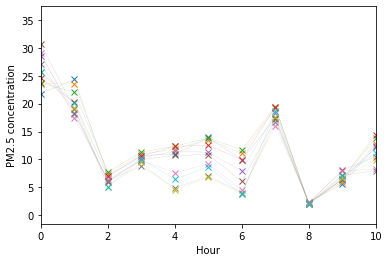

In [18]:
for series in pm25.reshape(-1, pm25.shape[-1])[:10]:
    plt.plot(series, lw=.1, marker='x')
plt.xlim(0, 10)
plt.xlabel("Hour")
plt.ylabel("PM2.5 concentration")

Single time stamp (i.e. region of North Italy)

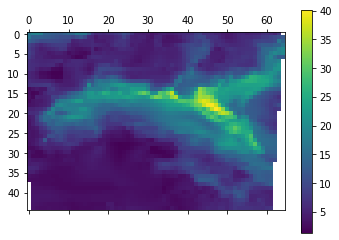

In [19]:
mappable = plt.matshow(pm25[..., -1])
plt.colorbar(mappable)

### Outputs (DEM/height above sea level)

In [20]:
dem = utils.open_dem()
print(land_cover.shape)

(45, 65)


In this demonstration we have a toy example: to try and predict height above sea level from our air quality time series. The values in this case are provided by a downsampled [Copernicus DEM](https://spacedata.copernicus.eu/collections/copernicus-digital-elevation-model).

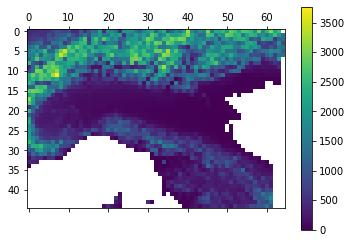

In [21]:
mappable = plt.matshow(dem)
plt.colorbar(mappable)

### Variable normalisation

In this example as well as normalising our input features (PM2.5 concentrations), we also normalise the outputs by performing min/max scaling to keep variables in the range 0 to 1.

As mentioned before, min/max scaling is sensitive to outliers so you may want to consider other more robust normalisation methods.

**We must remember to reverse this normalisation if we want to consider the model outputs in the original scale of meters above sea level**